# SISO System Identification for Ground Motion Events

In [1]:
import numpy as np
from numpy import linspace, sqrt, pi
from utilities.config import Config
from utilities.printing import *
import ssid
from ssid import modes
# from collections import defaultdict
import sdof
from quakeio.elcentro import accel as elcentro

## Unknown system with one input and one output
parameter | value
----------|-------
$\omega_n$  | natural period
$\zeta$  | damping ratio

![sdof2](./figures/sdof2.png)

## Configure

#### Inputs

In [2]:
input  = elcentro.data
dt = elcentro["time_step"]

# ta = np.arange(0, input.size*dt, dt)
t = linspace(0, (input.size-1)*dt, len(input))

#### Outputs

In [3]:
output = None

In [4]:
# Example SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio

#### Method

In [5]:

conf = Config()
conf.r = 2


Generate output if one was not given:

In [6]:
if output is None:
    omega_n = sqrt(k/mass)  # natural frequency (rad/s)
    Tn = 2*pi/omega_n  # natural periods (s)
    c = 2*zeta*mass*omega_n    # damping coefficient
    print(f"natural period: {Tn:<3.5}s")
    print(f"damping ratio:  {zeta}")
    displ, veloc, output = sdof.integrate(mass,c,k,input,dt)

natural period: 1.1471s
damping ratio:  0.01


## Analysis

### Perform System Identification

In [7]:
# Generate a state space realization of the system
realization = ssid.system(input=input, output=output, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modes.modes(realization, dt)
print_modes(ss_modes, Tn=Tn, zeta=zeta)

Spectral quantities:
         T         ζ          T % error    ζ % error
      1.148      0.00998      0.0999       -0.1995  


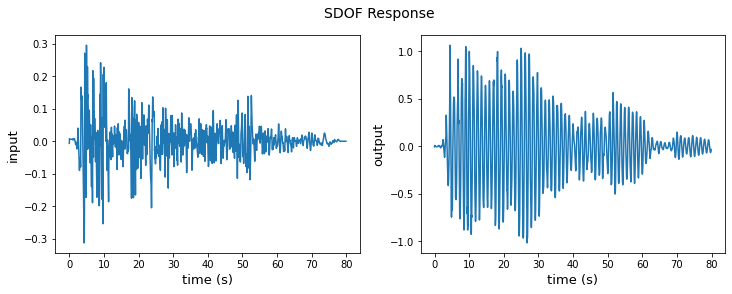

In [8]:
plot_io(input=input, output=output, t=t, title="SDOF Response")

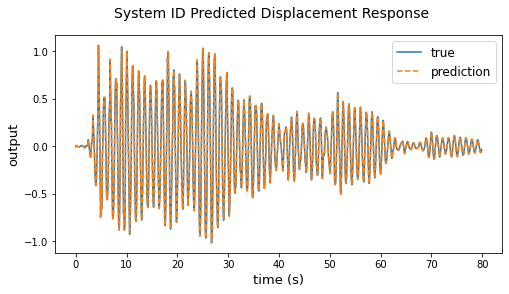

In [9]:
# Reproduce the response with the state space model
from control.matlab import ss, lsim
out_ssid = lsim(ss(*realization,dt),input,t)[0]
plot_pred(ytrue=output, models=out_ssid, t=t, title="System ID Predicted Displacement Response")